# Supplement Sales Prediction

Your Client WOMart is a leading nutrition and supplement retail chain that offers a comprehensive range of products for all your wellness and fitness needs. 

WOMart follows a multi-channel distribution strategy with 350+ retail stores spread across 100+ cities. 

Effective forecasting for store sales gives essential insight into upcoming cash flow, meaning WOMart can more accurately plan the cashflow at the store level.

Sales data for 18 months from 365 stores of WOMart is available along with information on Store Type, Location Type for each store, Region Code for every store, Discount provided by the store on every day, Number of Orders everyday etc.

**Your task is to predict the store sales for each store in the test set for the next two months.**

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
train1 = pd.read_csv('TRAIN (1).csv')
test =  pd.read_csv('TEST_FINAL.csv')

In [ ]:
train = train1[train1['Sales']!=0]

In [ ]:
train.shape, test.shape

((188321, 10), (22265, 8))

In [ ]:
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [ ]:
train.drop(columns=['ID','#Order'],axis=1, inplace=True)
test.drop(columns=['ID'],axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#Data Manipulation

In [ ]:
train1.skew()

Store_id    0.000000
Holiday     2.177176
#Order      1.372874
Sales       1.248819
dtype: float64

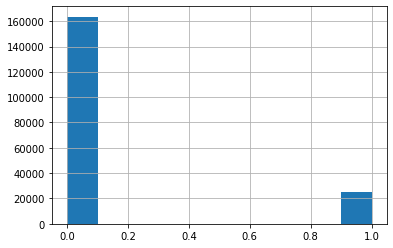

In [ ]:
train1['Holiday'].hist();

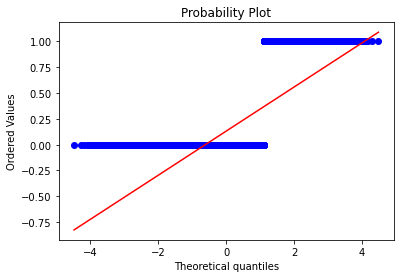

In [ ]:
#importing necessary libraries
import scipy.stats as stats
import pylab

stats.probplot(train1.Holiday,plot=pylab);


In [ ]:

#performing logarithmic transformation on the feature
train1['Holiday']=np.log(train1['Holiday'])


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


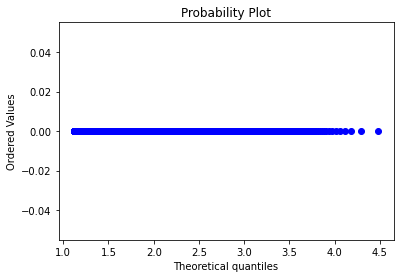

In [ ]:
stats.probplot(train1.Holiday,plot=pylab);


In [ ]:
train1['Sales']=1/train1.Sales


In [ ]:
#As the data is Time-Series we sort them in ascending order so that the model can perform on the historical data
# sorting data with respect to date
train = train.sort_values(by='Date')


#Exploratory Data Analysis

In [ ]:
size = train['Store_Type'].value_counts() #There are a total of 4 types of stores: S1, S2, S3, S4.There are 45 stores in total 188340

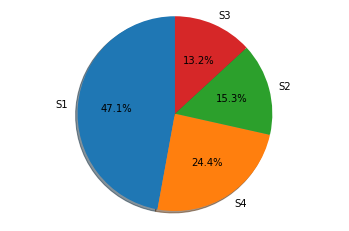

In [ ]:
#pie-chart for the visual representation of store types
import matplotlib.pyplot as plt
labels = 'S1','S4','S2', 'S3'
sizes = [(88752/(188340))*100,(45924/(188340))*100,(28896/(188340))*100, (24768/(188340))*100]
fig1, ax1 = plt.subplots()
ax1.pie(size, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
size

S1    88745
S4    45913
S2    28896
S3    24767
Name: Store_Type, dtype: int64

#By boxplot and piechart, we can say that type S1 store is largest amoung all

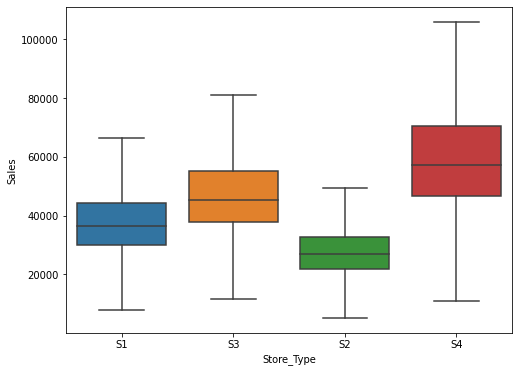

In [ ]:
#boxplot for weekly sales for different types of stores :
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Store_Type', y='Sales', data=train, showfliers=False)

In [ ]:
# total count of sales on holidays and non holidays
print('sales on non-holiday : ',train[train['Holiday']==False]['Sales'].count().round(1))
print('sales on holiday : ',train[train['Holiday']==True]['Sales'].count().round(1))

sales on non-holiday :  163506
sales on holiday :  24815


[]

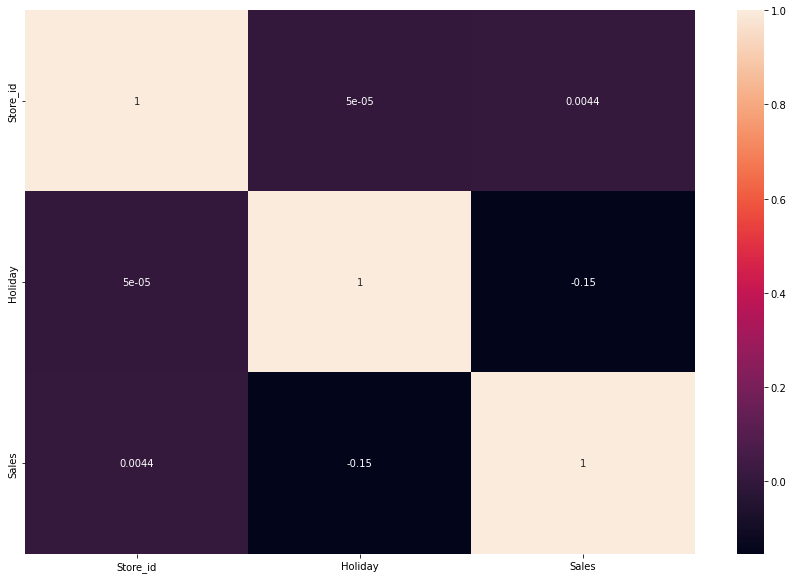

In [ ]:
# Plotting correlation between all important features
corr = train.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True)
plt.plot()

In [ ]:
##Splitting Date into features


In [ ]:
# Add column for year
train["Year"] = pd.to_datetime(train["Date"], format="%Y-%m-%d").dt.year
test["Year"] = pd.to_datetime(test["Date"], format="%Y-%m-%d").dt.year

# Add column for day
train["Day"] = pd.to_datetime(train["Date"], format="%Y-%m-%d").dt.day
test["Day"] = pd.to_datetime(test["Date"], format="%Y-%m-%d").dt.day

train["month"] = pd.to_datetime(train["Date"], format="%Y-%m-%d").dt.month
test["month"] = pd.to_datetime(test["Date"], format="%Y-%m-%d").dt.month


# Add column for days to next Christmas
train["Days to Next Christmas"] = (pd.to_datetime(train["Year"].astype(str)+"-12-31", format="%Y-%m-%d") -
                                   pd.to_datetime(train["Date"], format="%Y-%m-%d")).dt.days.astype(int)
test["Days to Next Christmas"] = (pd.to_datetime(test["Year"].astype(str)+"-12-31", format="%Y-%m-%d") -
                                   pd.to_datetime(test["Date"], format="%Y-%m-%d")).dt.days.astype(int)                                                                    

In [ ]:
#Splitting Store type into categorical features.
tp = pd.get_dummies(train['Store_Type'],drop_first = True)
train = pd.concat([train, tp], axis=1)
train = train.drop(columns='Store_Type')

tp1 = pd.get_dummies(test['Store_Type'],drop_first = True)
test = pd.concat([test, tp1], axis=1)
test = test.drop(columns='Store_Type')

rc = pd.get_dummies(train['Region_Code'],drop_first = True)
train = pd.concat([train, rc], axis=1)
train = train.drop(columns='Region_Code')

rc1 = pd.get_dummies(test['Region_Code'],drop_first = True)
test = pd.concat([test, rc1], axis=1)
test = test.drop(columns='Region_Code')

Discount = pd.get_dummies(train['Discount'],drop_first = True)
train = pd.concat([train, Discount], axis=1)
train = train.drop(columns='Discount')
train.head()

Discount1 = pd.get_dummies(test['Discount'],drop_first = True)
test = pd.concat([test, Discount1], axis=1)
test = test.drop(columns='Discount')
test.head()

,Store_id,Location_Type,Date,Holiday,Year,Day,month,Days to Next Christmas,S2,S3,S4,R2,R3,R4,Yes
0,171,L2,2019-06-01,0,2019,1,6,213,0,0,1,0,1,0,0
1,172,L1,2019-06-01,0,2019,1,6,213,0,0,0,0,0,0,0
2,173,L2,2019-06-01,0,2019,1,6,213,0,0,1,0,0,0,0
3,174,L1,2019-06-01,0,2019,1,6,213,0,0,0,0,0,1,0
4,170,L1,2019-06-01,0,2019,1,6,213,0,0,0,1,0,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188321 entries, 0 to 188339
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Store_id                188321 non-null  int64  
 1   Location_Type           188321 non-null  object 
 2   Date                    188321 non-null  object 
 3   Holiday                 188321 non-null  int64  
 4   Sales                   188321 non-null  float64
 5   Year                    188321 non-null  int64  
 6   Day                     188321 non-null  int64  
 7   month                   188321 non-null  int64  
 8   Days to Next Christmas  188321 non-null  int64  
 9   S2                      188321 non-null  uint8  
 10  S3                      188321 non-null  uint8  
 11  S4                      188321 non-null  uint8  
 12  R2                      188321 non-null  uint8  
 13  R3                      188321 non-null  uint8  
 14  R4                  

In [ ]:
#Building train-test set
#splitting final data into train and test. We kept 80%of train data and 20% test data.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188321 entries, 0 to 188339
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Store_id                188321 non-null  int64  
 1   Location_Type           188321 non-null  object 
 2   Date                    188321 non-null  object 
 3   Holiday                 188321 non-null  int64  
 4   Sales                   188321 non-null  float64
 5   Year                    188321 non-null  int64  
 6   Day                     188321 non-null  int64  
 7   month                   188321 non-null  int64  
 8   Days to Next Christmas  188321 non-null  int64  
 9   S2                      188321 non-null  uint8  
 10  S3                      188321 non-null  uint8  
 11  S4                      188321 non-null  uint8  
 12  R2                      188321 non-null  uint8  
 13  R3                      188321 non-null  uint8  
 14  R4                  

In [ ]:
train.drop('Date',axis=1,inplace=True)
test.drop('Date',axis=1,inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188321 entries, 0 to 188339
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Store_id                188321 non-null  int64  
 1   Location_Type           188321 non-null  object 
 2   Holiday                 188321 non-null  int64  
 3   Sales                   188321 non-null  float64
 4   Year                    188321 non-null  int64  
 5   Day                     188321 non-null  int64  
 6   month                   188321 non-null  int64  
 7   Days to Next Christmas  188321 non-null  int64  
 8   S2                      188321 non-null  uint8  
 9   S3                      188321 non-null  uint8  
 10  S4                      188321 non-null  uint8  
 11  R2                      188321 non-null  uint8  
 12  R3                      188321 non-null  uint8  
 13  R4                      188321 non-null  uint8  
 14  Yes                 

In [ ]:
enc = train[['Location_Type','Year']]
enc1 = test[['Location_Type','Year']]

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
enc = enc.apply(le.fit_transform)
enc.head()

le = preprocessing.LabelEncoder()
enc1 = enc1.apply(le.fit_transform)

In [ ]:
#Concatinating categorical dataframe with original dataframe
train = train.drop(train[['Location_Type','Year']], axis=1)
train = pd.concat([train,enc], axis=1)
train.head()

test = test.drop(test[['Location_Type','Year']], axis=1)
test = pd.concat([test,enc1], axis=1)
test.head()

,Store_id,Holiday,Day,month,Days to Next Christmas,S2,S3,S4,R2,R3,R4,Yes,Location_Type,Year
0,171,0,1,6,213,0,0,1,0,1,0,0,1,0
1,172,0,1,6,213,0,0,0,0,0,0,0,0,0
2,173,0,1,6,213,0,0,1,0,0,0,0,1,0
3,174,0,1,6,213,0,0,0,0,0,1,0,0,0
4,170,0,1,6,213,0,0,0,1,0,0,0,0,0


In [ ]:
train.head(5)

,Store_id,Holiday,Sales,Day,month,Days to Next Christmas,S2,S3,S4,R2,R3,R4,Yes,Location_Type,Year
0,1,1,7011.84,1,1,364,0,0,0,0,0,0,1,2,0
248,64,1,42293.94,1,1,364,0,1,0,1,0,0,1,0,0
247,65,1,46070.64,1,1,364,0,0,0,1,0,0,1,1,0
246,66,1,26151.12,1,1,364,0,1,0,0,1,0,1,2,0
245,67,1,44949.45,1,1,364,1,0,0,0,0,0,1,4,0


In [ ]:
x = train.drop('Sales', axis=1).values
y = train.Sales.values

In [ ]:
test.head()

,Store_id,Holiday,Day,month,Days to Next Christmas,S2,S3,S4,R2,R3,R4,Yes,Location_Type,Year
0,171,0,1,6,213,0,0,1,0,1,0,0,1,0
1,172,0,1,6,213,0,0,0,0,0,0,0,0,0
2,173,0,1,6,213,0,0,1,0,0,0,0,1,0
3,174,0,1,6,213,0,0,0,0,0,1,0,0,0
4,170,0,1,6,213,0,0,0,1,0,0,0,0,0


In [ ]:
#train-test split
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split( x, y, test_size=0.20, random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[0.78571429, 0.        , 0.3       , ..., 0.        , 0.75      ,
        0.        ],
       [0.61813187, 0.        , 0.46666667, ..., 1.        , 1.        ,
        0.        ],
       [0.06318681, 0.        , 0.1       , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.84065934, 0.        , 0.06666667, ..., 0.        , 1.        ,
        0.        ],
       [0.3543956 , 1.        , 0.43333333, ..., 1.        , 0.        ,
        0.        ],
       [0.37637363, 0.        , 0.23333333, ..., 1.        , 0.        ,
        1.        ]])

In [ ]:
import lightgbm as ltb
xgb_clf = ltb.LGBMRegressor(
                          alpha=0.1,
                          learningRate=0.1,
                          numIterations=70,
                          numLeaves=20,n_estimators=1000,min_child_samples=50)
xgb_clf.fit(X_train,y_train)            
y_pred=xgb_clf.predict(X_test)

print("Bagging with Random Forest Classifier :Accuracy ", (r2_score(y_test,y_pred)))

Bagging with Random Forest Classifier :Accuracy  0.8411449797990511


In [ ]:
print(xgb_clf.score(X_train,y_train))
print(xgb_clf.score(X_test,y_test))




0.8588220813645988
0.8411449797990511


In [ ]:
from sklearn.metrics import mean_squared_log_error
print(mean_squared_log_error(y_test, y_pred))

ValueError: ignored

In [ ]:
preds=xgb_clf.predict(test)


In [ ]:
preds

In [ ]:
sample =  pd.read_csv('TEST_FINAL.csv')
pid = sample['ID'].values
pid

In [ ]:
out_df = pd.DataFrame({'ID' : pid,'Sales': preds})
out_df.head()

In [ ]:
out_df.to_csv('submission.csv', index=False)

In [ ]:
out_df